In [1]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks

imports work


<!-- <span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data -->

In [ ]:
hit_data_1101 = rf.get_ROOT_data_zip("TB_FIRE_1101_hits.root")

# hit_data_1096 = rf.get_ROOT_data_zip("TB_FIRE_1096_hits.root")

# hit_data_1056 = rf.get_ROOT_data_zip("TB_FIRE_1056_hits.root")

# hit_data_1057 = rf.get_ROOT_data_zip("TB_FIRE_1057_hits.root")

# hit_data_1079 = rf.get_ROOT_data_zip("TB_FIRE_1079_hits.root")

TB_FIRE_1101_hits.root finished


<!-- <span style="font-family: arial; font-size:25px; color:pink">

Hit Counts and Amp in Single Planes -->

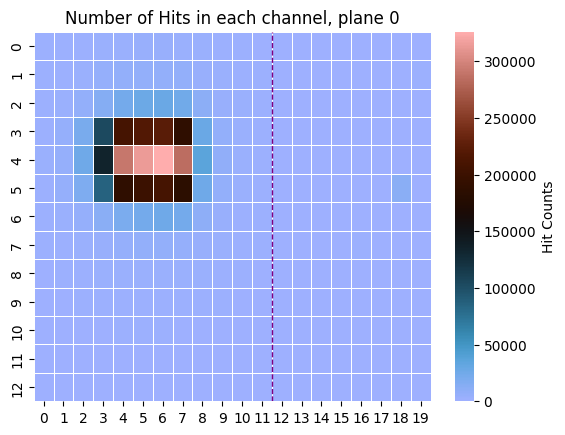

In [12]:
rf.hits_amount_colormap_single_plane(hit_data_1101_update, 0)

In [5]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 7, cmap="managua")

In [6]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 0, cmap="managua")

In [7]:
# rf.single_event_evolution_amp(hit_data_1101, 54106, cmap="managua")

In [8]:
# plt.clf()   # Clear the current figure
# plt.close() # Close any open figures
# %matplotlib widget
# rf.amp_histo_single_plane(hit_data_1101,1)

In [9]:
# rf.average_amp_vs_plane(hit_data_1101)

In [10]:
# # shower initial starting points
# rf.plot_empty_first_planes(hit_data_1101)

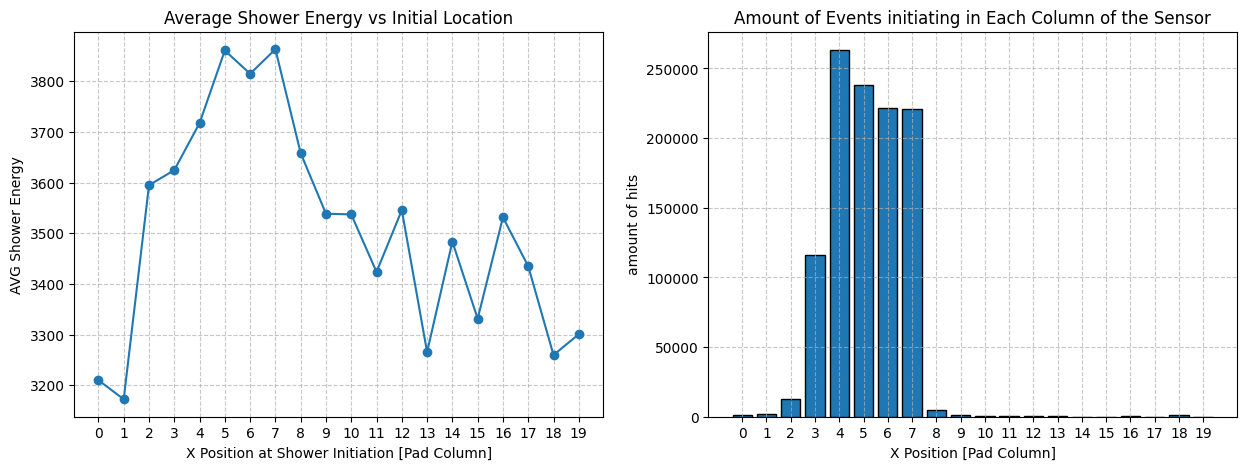

In [13]:
rf.event_shower_energy_vs_X_position(hit_data_1101_update, single_pad_only="true")

In [12]:
# returns histogram of the amount of hits with the same energy in given X position
def shower_energy_histo_single_location(hit_data, Position):

    # get only showers starting at the first plane to identify the initial location
    plane_7 = hit_data_1101[hit_data_1101.plane == 7]
    mask = ak.num(plane_7) > 0
    first_plane_starting_events = hit_data_1101[mask]

    # determine the initial location of the shower
    # get the data on the first plane
    plane_7_clean = plane_7[mask]
    plane_7_channel = plane_7_clean.ch
    # divide by x positions
    y, x = divmod(plane_7_channel, 20) #y is the quontinent and is the row, x is the remainder and column
    x_list = x.to_list()
    x_ak = ak.Array(x_list)
    x_avg = ak.mean(x_ak, axis = 1)
    print("avg ok")
    # compute the shower energy for each event
    hit_amp_array = first_plane_starting_events.amp
    event_shower_amp_array = ak.sum(hit_amp_array, axis = 1)
    print("shower per event ok")
    # get the shower energy for the X position for all events
    amps_divided_by_class, avg_amps, classes = rf.ak_groupby(x_avg, event_shower_amp_array)
    print("groupby ok")
    # div, avg_amps, classes = ak_groupby(x_avg, event_shower_amp_array)

    amps_class_position = amps_divided_by_class[amps_divided_by_class.classes == Position]
    print("amps class at position ok")
    amps_position = amps_class_position.data
    print("amp position ok")
    amps_position_clean = amps_position[ak.num(amps_position) > 0]
    print("amp position clean ok")




    # Plot
    plt.hist(amps_position_clean[0], bins=100, range=(0,500))
    plt.show()



In [13]:
# shower_energy_histo_single_location(hit_data_1101,5)


[2 3 4 5 6 7]
2
[2.198269048371799, 3.1603290488431877, 3.871015282740799, 4.838305597579425, 6.574597719106389, 5.640643053508108, 6.860022754036845, 6.4659436871953035]
3
[1.8254943912826362, 3.037830936133871, 3.68197935610307, 4.759995197005582, 6.677738353374072, 5.703830388923625, 6.895078048900276, 6.5608561544761494]
4
[1.711455987035315, 3.0490551548708282, 3.639604234954624, 4.820518363616516, 6.67514262980582, 6.015625032983132, 6.91655703099552, 6.674603625737642]
5
[1.8404552836061723, 3.2004513468335802, 3.982335392687881, 4.994403087834661, 6.709466995639977, 6.379445797934801, 6.809896368063093, 6.808746405536777]
6
[1.8777883155490722, 3.2664270529706982, 4.105078616148392, 4.964837384279325, 6.699953368681024, 6.442541852046551, 6.7597643277986075, 6.797581296955403]
7
[1.6286689818679667, 3.0874899981003585, 3.8166402868310727, 4.6607215437044704, 6.652465806422248, 6.307588397998652, 6.7823943602729, 6.721187568531275]


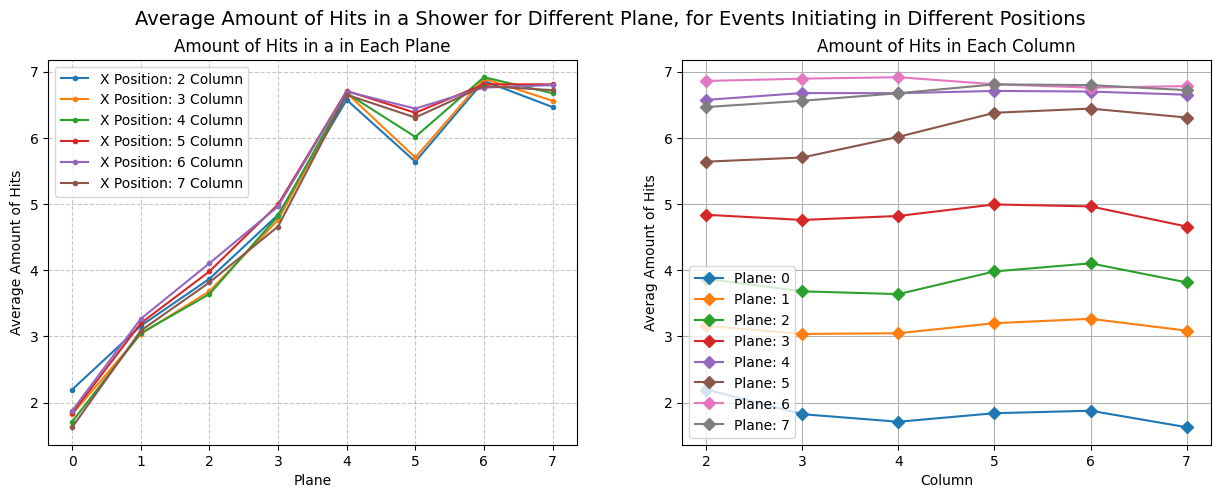

In [3]:
rf.avg_hit_amount_vs_plane_per_X_position(hit_data_1101,6)

In [ ]:


# # get the k columns with the maximum amount of hits
# def columns_with_max_hits(hit_data, number_of_columns):

#     # get the initial x positions
#     x_avg = rf.initial_X_position_DUT(hit_data)
#     # x_avg = ak.round(x_avg)

#     x_avg_np = ak.to_numpy(x_avg)

#     # Compute histogram for X positions
#     counts, bin_edges = np.histogram(x_avg, bins=np.arange(0, 21))

#     # get the positions with the highest entries
#     bins = np.arange(0, 20)

#     # Get indices that would sort counts descending
#     top_indices = np.argsort(-counts)[:number_of_columns]

#     # Get the corresponding bin numbers
#     top_bins = bins[top_indices]
#     top_counts = counts[top_indices]

#     return top_bins
    

In [ ]:

# # average amount of hits in a shower vs columns and planes
# def avg_ENERGY_vs_plane_per_X_position(hit_data, number_of_highest_ocupied_columns):
    
#     planes = np.arange(0,8)

#     # attach the positions to the data
#     positions = rf.initial_X_position_DUT(hit_data)
#     plane_7 = hit_data[hit_data.plane == 7]
#     mask = ak.num(plane_7) > 0
#     events_starting_at_7 = hit_data[mask]
#     hit_data_positions = ak.zip({ "hits":events_starting_at_7, "positions":positions},depth_limit=1)
    
#     # get the most ocupied columns
#     top_columns = columns_with_max_hits(hit_data, number_of_highest_ocupied_columns)
#     top_columns = np.sort(top_columns)
#     print(top_columns)

#     # array to store all the data of planes per column
#     total_avg_energy_planes = []

#     # create to plot figure
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
#     for column in top_columns:
#         print(column)
#         # creat an array to store the average ENERGY in each plane
#         energy_plane_array = []

#         # get the data of events initiating in the wanted column
#         hit_data_column = hit_data_positions[(hit_data_positions.positions >= column) & (hit_data_positions.positions < column + 1)]


#         # find the amount of hits in a plane for the column and add to the array
#         for plane in planes:
#             plane = 7-plane #adjust index so the first plane is 0
#             hit_data_column_plane = hit_data_column.hits[hit_data_column.hits.plane == plane] # the events initiatin at the wanted column and a specific plane 
#             hit_data_column_plane = hit_data_column_plane[ak.num(hit_data_column_plane) > 0] # clean from empty entries
#             num_of_events_column_plane = len(hit_data_column_plane)
#             energy_column_plane = ak.sum(hit_data_column_plane.amp)
#             avg_shower_energy_of_event_column_plane = energy_column_plane / num_of_events_column_plane
#             energy_plane_array.append(avg_shower_energy_of_event_column_plane)

#         #  add the array of energies for a single column to the total data array.
#         total_avg_energy_planes.append(energy_plane_array)
#         print(energy_plane_array)

#         # plot avg amount of hits per plane
#         ax1.plot(planes, energy_plane_array, label=f"X Position: {column} Column", marker=".")
#         ax1.grid(True, linestyle="--", alpha=0.7)
#         ax1.set_xlabel("Plane")
#         ax1.set_ylabel("Average Shower Energy")
#         ax1.set_title("Shower Energy of Hits in Each Plane")
#         ax1.legend()



    
#     # plot avg amount of hits per position
#     total_avg_energy_columns = np.transpose(np.array(total_avg_energy_planes))
#     for plane in planes:
#         avg_energy_plane_column = total_avg_energy_columns[plane]
#         ax2.plot(top_columns, avg_energy_plane_column, label = f"Plane: {plane}", marker="D")
#         ax2.set_xlabel('Column')
#         ax2.set_ylabel('Average Shower Energy')
#         ax2.set_title('Shower Energy in Each Column')
#         ax2.grid(True)
#         ax2.legend()

#     fig.suptitle("Average Shower Energy for Different Planes, for Events Initiating in Different Positions", fontsize=14)
#     plt.show()



In [ ]:
rf.avg_ENERGY_vs_plane_per_X_position(hit_data_1101, 6, print_energies = "true")


TypeError: avg_ENERGY_vs_plane_per_X_position() got an unexpected keyword argument 'print_energies'

In [29]:
a

<Array [[{plane: 7, ch: 142, ...}, ...], ...] type='50608 * var * {plane: i...'>

In [28]:
ak.sum(a.amp)

np.int64(8838847)